# %% [markdown]
# # 🏥 HEART DISEASE PREDICTION PIPELINE
# ## Complete ML System - From Data to Deployment
# 
# **Objective:** Predict heart disease with 90%+ accuracy using patient medical data
# **Algorithms:** SVM, Logistic Regression, Random Forest, XGBoost
# **Author:** Your Name | **Date:** 2024

In [13]:
# ## 1. Environment Setup

# %%

import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime

sys.path.append('..')
from src.config.settings import ProjectConfig
from src.utils.logger import setup_logging
from src.data.loader import DataLoader
from src.data.preprocessor import DataPreprocessor
from src.data.validator import DataValidator
from src.eda.outlier_detector import detect_outliers_iqr

from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score






config = ProjectConfig.load("heart")
logger = setup_logging("heart_pipeline")
logger.info("✅ Heart disease prediction pipeline initialized")

2026-02-25 14:07:47 - heart_pipeline - INFO - ✅ Heart disease prediction pipeline initialized


In [14]:
# ## 2. Data Loading & Validation

loader = DataLoader(config)
df = loader.load_heart_disease()
validator = DataValidator(config)
report = validator.generate_quality_report(df)
print(f"✅ Dataset loaded: {df.shape[0]} patients, {df.shape[1]} features")

✅ Dataset loaded: 1025 patients, 14 features


In [15]:
# %% [markdown]
# ## 3. Initial Data Inspection

# %%
print("📊 FIRST 5 ROWS:")
display(df.head())

print("\n📊 DATA INFO:")
print(df.info())

print("\n📊 BASIC STATISTICS:")
display(df.describe())

📊 FIRST 5 ROWS:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



📊 DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int32  
dtypes: float64(1), int32(1), int64(12)
memory usage: 108.2 KB
None

📊 BASIC STATISTICS:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [16]:
# %% [markdown]
# ## 4. Missing Values Analysis

# %%
missing = pd.DataFrame({
    'Column': df.columns,
    'Missing': df.isnull().sum().values,
    'Percentage': (df.isnull().sum() / len(df) * 100).values
}).sort_values('Percentage', ascending=False)

print("🔍 MISSING VALUES REPORT:")
display(missing[missing['Missing'] > 0])

print(f"\n✅ Total missing: {df.isnull().sum().sum()} cells")

🔍 MISSING VALUES REPORT:


,Column,Missing,Percentage



✅ Total missing: 0 cells


In [17]:
# %% [markdown]
# ## 5. Duplicate Check

# %%
duplicates = df.duplicated().sum()
print(f"📊 DUPLICATE ROWS: {duplicates}")
print(f"Percentage: {(duplicates/len(df))*100:.2f}%")

if duplicates > 0:
    print("⚠️ Duplicates found - will remove during preprocessing")

📊 DUPLICATE ROWS: 723
Percentage: 70.54%
⚠️ Duplicates found - will remove during preprocessing


In [18]:
# %% [markdown]
# ## 6. Target Variable Distribution

# %%
target_dist = df['target'].value_counts()
target_pct = df['target'].value_counts(normalize=True) * 100

print("🎯 TARGET DISTRIBUTION:")
print(f"No Disease: {target_dist[0]} ({target_pct[0]:.1f}%)")
print(f"Disease:    {target_dist[1]} ({target_pct[1]:.1f}%)")

if target_pct.min() < 30:
    print("⚠️ Imbalanced dataset - will apply SMOTE")

🎯 TARGET DISTRIBUTION:
No Disease: 499 (48.7%)
Disease:    526 (51.3%)


In [19]:
# %% [markdown]
# ## 7. Data Types Analysis

# %%
dtype_df = pd.DataFrame({
    'Column': df.columns,
    'Type': df.dtypes.values,
    'Unique': [df[col].nunique() for col in df.columns]
})

print("📊 DATA TYPES:")
display(dtype_df)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n✅ Numeric columns: {len(numeric_cols)}")

📊 DATA TYPES:


,Column,Type,Unique
0,age,int64,41
1,sex,int64,2
2,cp,int64,4
3,trestbps,int64,49
4,chol,int64,152
5,fbs,int64,2
6,restecg,int64,3
7,thalach,int64,91
8,exang,int64,2
9,oldpeak,float64,40



✅ Numeric columns: 14


In [20]:
# %% [markdown]
# ## 8. Detailed Statistics

# %%
stats_df = df.describe().T
stats_df['skew'] = df[numeric_cols].skew()
stats_df['kurtosis'] = df[numeric_cols].kurtosis()

print("📈 STATISTICAL SUMMARY:")
display(stats_df.round(2))

📈 STATISTICAL SUMMARY:


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,1025.0,54.43,9.07,29.0,48.0,56.0,61.0,77.0,-0.25,-0.53
sex,1025.0,0.70,0.46,0.0,0.0,1.0,1.0,1.0,-0.85,-1.28
cp,1025.0,0.94,1.03,0.0,0.0,1.0,2.0,3.0,0.53,-1.15
trestbps,1025.0,131.61,17.52,94.0,120.0,130.0,140.0,200.0,0.74,0.99
chol,1025.0,246.00,51.59,126.0,211.0,240.0,275.0,564.0,1.07,4.00
fbs,1025.0,0.15,0.36,0.0,0.0,0.0,0.0,1.0,1.97,1.89
restecg,1025.0,0.53,0.53,0.0,0.0,1.0,1.0,2.0,0.18,-1.31
thalach,1025.0,149.11,23.01,71.0,132.0,152.0,166.0,202.0,-0.51,-0.09
exang,1025.0,0.34,0.47,0.0,0.0,0.0,1.0,1.0,0.69,-1.52
oldpeak,1025.0,1.07,1.18,0.0,0.0,0.8,1.8,6.2,1.21,1.31


In [21]:
# %% [markdown]
# ## 9. Outlier Detection (IQR Method)


outliers = detect_outliers_iqr(df, numeric_cols)
outlier_df = pd.DataFrame(outliers).T.round(2)

print("🔍 OUTLIER REPORT:")
display(outlier_df)

cols_with_outliers = outlier_df[outlier_df['percentage'] > 5].index.tolist()
print(f"\n⚠️ Columns with >5% outliers: {cols_with_outliers}")

🔍 OUTLIER REPORT:


,count,percentage,lower_bound,upper_bound,min,max
age,0.0,0.00,28.5,80.5,29.0,77.0
sex,0.0,0.00,-1.5,2.5,0.0,1.0
cp,0.0,0.00,-3.0,5.0,0.0,3.0
trestbps,30.0,2.93,90.0,170.0,94.0,200.0
chol,16.0,1.56,115.0,371.0,126.0,564.0
fbs,153.0,14.93,0.0,0.0,0.0,1.0
restecg,0.0,0.00,-1.5,2.5,0.0,2.0
thalach,4.0,0.39,81.0,217.0,71.0,202.0
exang,0.0,0.00,-1.5,2.5,0.0,1.0
oldpeak,7.0,0.68,-2.7,4.5,0.0,6.2



⚠️ Columns with >5% outliers: ['fbs', 'ca']


In [23]:
# %% [markdown]
# ## Debug Outlier Detection

# %%
# Check what the function returns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'target' in numerical_cols:
    numerical_cols.remove('target')

outlier_info = detect_outliers_iqr(df, numerical_cols)
print("🔍 RAW OUTLIER FUNCTION OUTPUT:")
print(outlier_info)
print("\n" + "="*50)

🔍 RAW OUTLIER FUNCTION OUTPUT:
{'age': {'count': 0, 'percentage': 0.0, 'lower_bound': 28.5, 'upper_bound': 80.5, 'min': 29, 'max': 77}, 'sex': {'count': 0, 'percentage': 0.0, 'lower_bound': -1.5, 'upper_bound': 2.5, 'min': 0, 'max': 1}, 'cp': {'count': 0, 'percentage': 0.0, 'lower_bound': -3.0, 'upper_bound': 5.0, 'min': 0, 'max': 3}, 'trestbps': {'count': 30, 'percentage': 2.9268292682926833, 'lower_bound': 90.0, 'upper_bound': 170.0, 'min': 94, 'max': 200}, 'chol': {'count': 16, 'percentage': 1.5609756097560976, 'lower_bound': 115.0, 'upper_bound': 371.0, 'min': 126, 'max': 564}, 'fbs': {'count': 153, 'percentage': 14.926829268292682, 'lower_bound': 0.0, 'upper_bound': 0.0, 'min': 0, 'max': 1}, 'restecg': {'count': 0, 'percentage': 0.0, 'lower_bound': -1.5, 'upper_bound': 2.5, 'min': 0, 'max': 2}, 'thalach': {'count': 4, 'percentage': 0.3902439024390244, 'lower_bound': 81.0, 'upper_bound': 217.0, 'min': 71, 'max': 202}, 'exang': {'count': 0, 'percentage': 0.0, 'lower_bound': -1.5, 'u

In [24]:
# %% [markdown]
# ## 10. Outlier Detection using IQR Method

# %%
# Get numerical columns (excluding target)
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'target' in numerical_cols:
    numerical_cols.remove('target')

print(f"📊 Analyzing {len(numerical_cols)} numerical columns for outliers...")

# Detect outliers using IQR method
outlier_info = detect_outliers_iqr(df, numerical_cols)

# Convert to DataFrame and rename columns for clarity
outlier_df = pd.DataFrame(outlier_info).T
outlier_df.columns = ['count', 'percentage', 'lower_bound', 'upper_bound', 'min', 'max']

print("\n🔍 OUTLIER DETECTION (IQR METHOD):")
print("="*80)
display(outlier_df.round(2))

# Highlight columns with significant outliers
significant_outliers = outlier_df[outlier_df['percentage'] > 5]
if len(significant_outliers) > 0:
    print("\n⚠️ COLUMNS WITH >5% OUTLIERS:")
    print("-" * 40)
    for col in significant_outliers.index:
        print(f"   • {col}: {significant_outliers.loc[col, 'percentage']:.2f}% outliers "
              f"({int(significant_outliers.loc[col, 'count'])} values)")
else:
    print("\n✅ No columns with >5% outliers detected!")

# Summary statistics
total_outliers = outlier_df['count'].sum()
avg_outlier_pct = outlier_df['percentage'].mean()
print(f"\n📊 SUMMARY:")
print(f"   • Total outliers across all columns: {int(total_outliers)}")
print(f"   • Average outlier percentage: {avg_outlier_pct:.2f}%")
print(f"   • Columns with outliers: {len(outlier_df[outlier_df['count'] > 0])}/{len(outlier_df)}")

📊 Analyzing 13 numerical columns for outliers...



🔍 OUTLIER DETECTION (IQR METHOD):


,count,percentage,lower_bound,upper_bound,min,max
age,0.0,0.00,28.5,80.5,29.0,77.0
sex,0.0,0.00,-1.5,2.5,0.0,1.0
cp,0.0,0.00,-3.0,5.0,0.0,3.0
trestbps,30.0,2.93,90.0,170.0,94.0,200.0
chol,16.0,1.56,115.0,371.0,126.0,564.0
fbs,153.0,14.93,0.0,0.0,0.0,1.0
restecg,0.0,0.00,-1.5,2.5,0.0,2.0
thalach,4.0,0.39,81.0,217.0,71.0,202.0
exang,0.0,0.00,-1.5,2.5,0.0,1.0
oldpeak,7.0,0.68,-2.7,4.5,0.0,6.2



⚠️ COLUMNS WITH >5% OUTLIERS:
----------------------------------------
   • fbs: 14.93% outliers (153 values)
   • ca: 8.49% outliers (87 values)

📊 SUMMARY:
   • Total outliers across all columns: 304
   • Average outlier percentage: 2.28%
   • Columns with outliers: 7/13


In [25]:
# %% [markdown]
# ## 10. Feature Correlation with Target

# %%
correlations = df[numeric_cols].corr()['target'].drop('target').sort_values(ascending=False)

print("📊 FEATURE CORRELATION WITH TARGET:")
for feat, corr in correlations.items():
    print(f"{feat:10}: {corr:+.3f}")

top_features = correlations.head(5).index.tolist()
print(f"\n✅ Top 5 features: {top_features}")

📊 FEATURE CORRELATION WITH TARGET:
cp        : +0.435
thalach   : +0.423
slope     : +0.346
restecg   : +0.134
fbs       : -0.041
chol      : -0.100
trestbps  : -0.139
age       : -0.229
sex       : -0.280
thal      : -0.338
ca        : -0.382
exang     : -0.438
oldpeak   : -0.438

✅ Top 5 features: ['cp', 'thalach', 'slope', 'restecg', 'fbs']


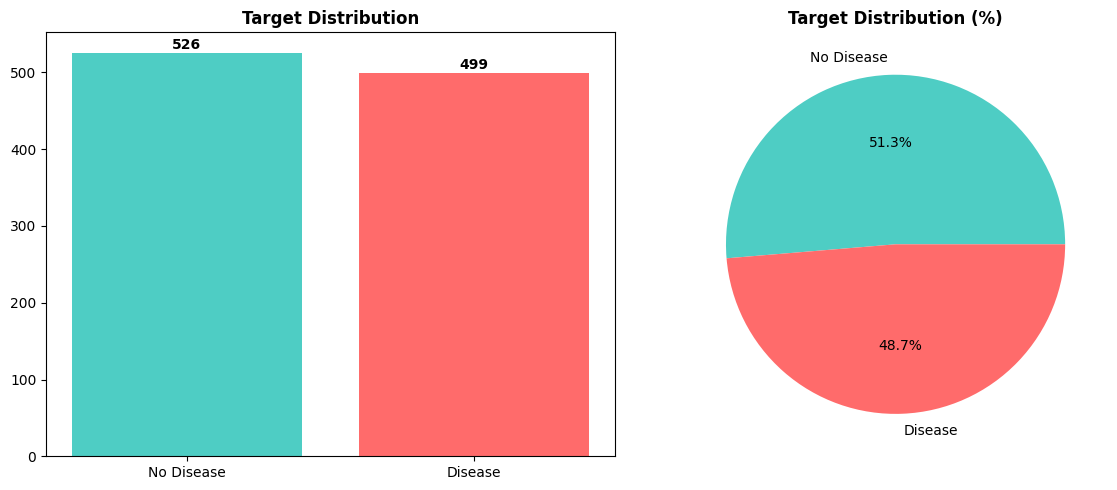

In [26]:
# %% [markdown]
# ## 11. Target Distribution Visualization

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(['No Disease', 'Disease'], target_dist.values, color=['#4ECDC4', '#FF6B6B'])
ax1.set_title('Target Distribution', fontweight='bold')
for i, v in enumerate(target_dist.values):
    ax1.text(i, v+5, str(v), ha='center', fontweight='bold')

ax2.pie(target_dist.values, labels=['No Disease', 'Disease'], 
        autopct='%1.1f%%', colors=['#4ECDC4', '#FF6B6B'])
ax2.set_title('Target Distribution (%)', fontweight='bold')

plt.tight_layout()
plt.show()

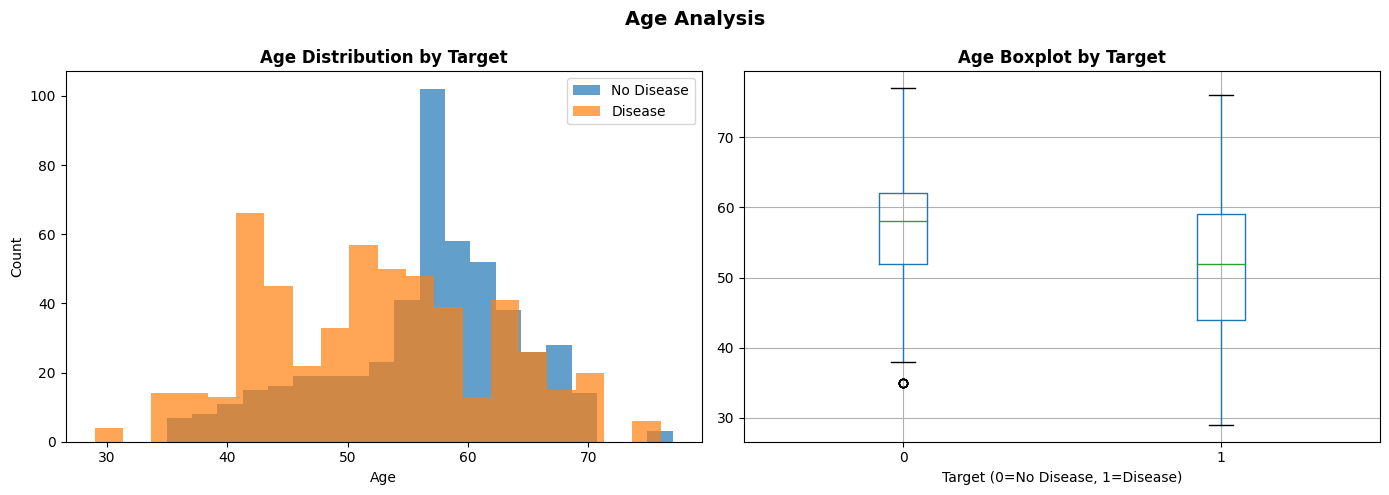

In [27]:
# %% [markdown]
# ## 12. Age Distribution by Target

# %%
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for target in [0, 1]:
    subset = df[df['target'] == target]['age']
    ax1.hist(subset, alpha=0.7, label=f'Target {target}', bins=20)
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')
ax1.set_title('Age Distribution by Target', fontweight='bold')
ax1.legend(['No Disease', 'Disease'])

df.boxplot(column='age', by='target', ax=ax2)
ax2.set_title('Age Boxplot by Target', fontweight='bold')
ax2.set_xlabel('Target (0=No Disease, 1=Disease)')

plt.suptitle('Age Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

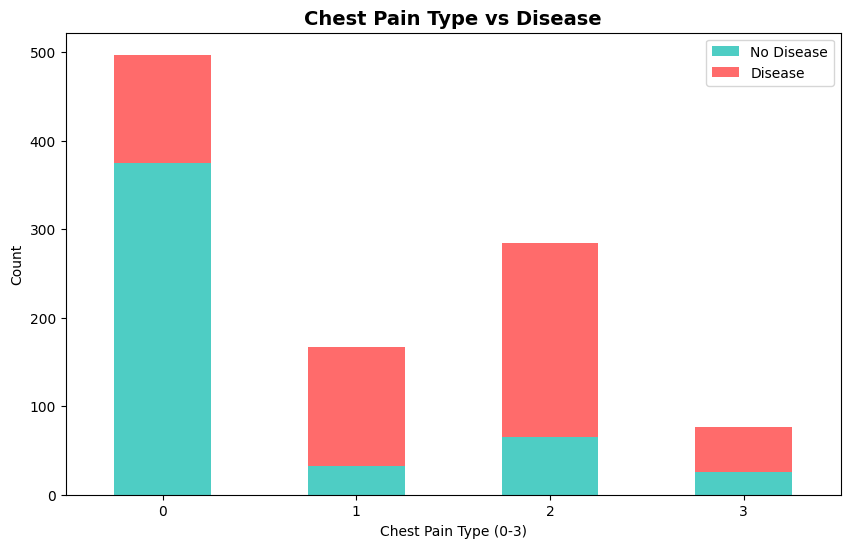

In [28]:
# %% [markdown]
# ## 13. Chest Pain Type Analysis

# %%
cp_cross = pd.crosstab(df['cp'], df['target'])
cp_cross.columns = ['No Disease', 'Disease']

fig, ax = plt.subplots(figsize=(10, 6))
cp_cross.plot(kind='bar', stacked=True, ax=ax, color=['#4ECDC4', '#FF6B6B'])
ax.set_title('Chest Pain Type vs Disease', fontweight='bold', fontsize=14)
ax.set_xlabel('Chest Pain Type (0-3)')
ax.set_ylabel('Count')
ax.legend(['No Disease', 'Disease'])
plt.xticks(rotation=0)
plt.show()

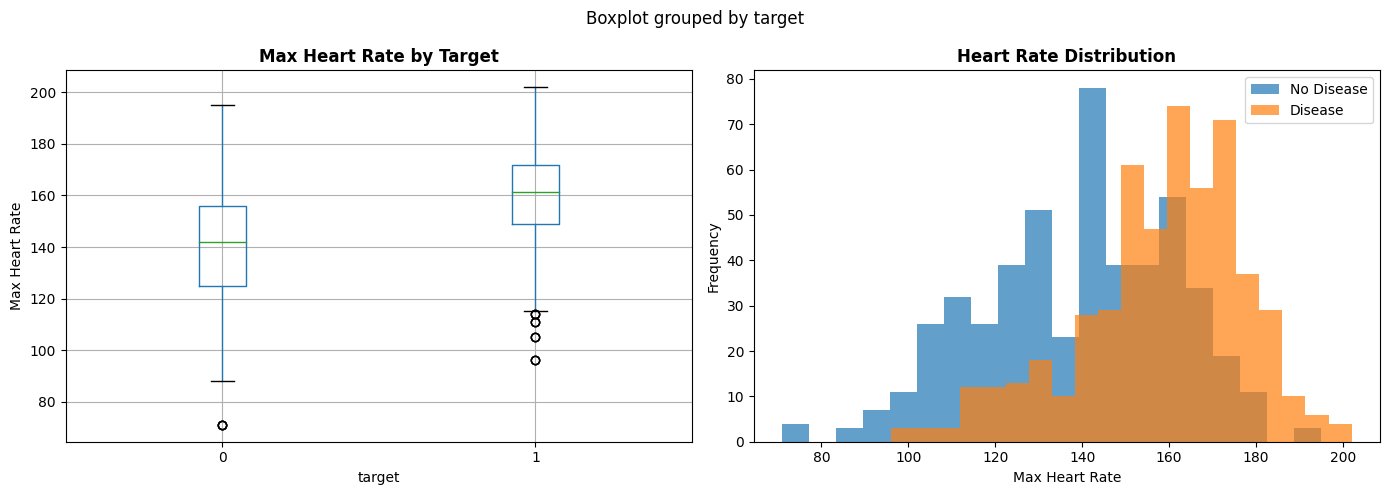

In [29]:
# %% [markdown]
# ## 14. Maximum Heart Rate Analysis

# %%
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

df.boxplot(column='thalach', by='target', ax=ax1)
ax1.set_title('Max Heart Rate by Target', fontweight='bold')
ax1.set_ylabel('Max Heart Rate')

for target in [0, 1]:
    subset = df[df['target'] == target]['thalach']
    ax2.hist(subset, alpha=0.7, label=f'Target {target}', bins=20)
ax2.set_xlabel('Max Heart Rate')
ax2.set_ylabel('Frequency')
ax2.set_title('Heart Rate Distribution', fontweight='bold')
ax2.legend(['No Disease', 'Disease'])

plt.tight_layout()
plt.show()

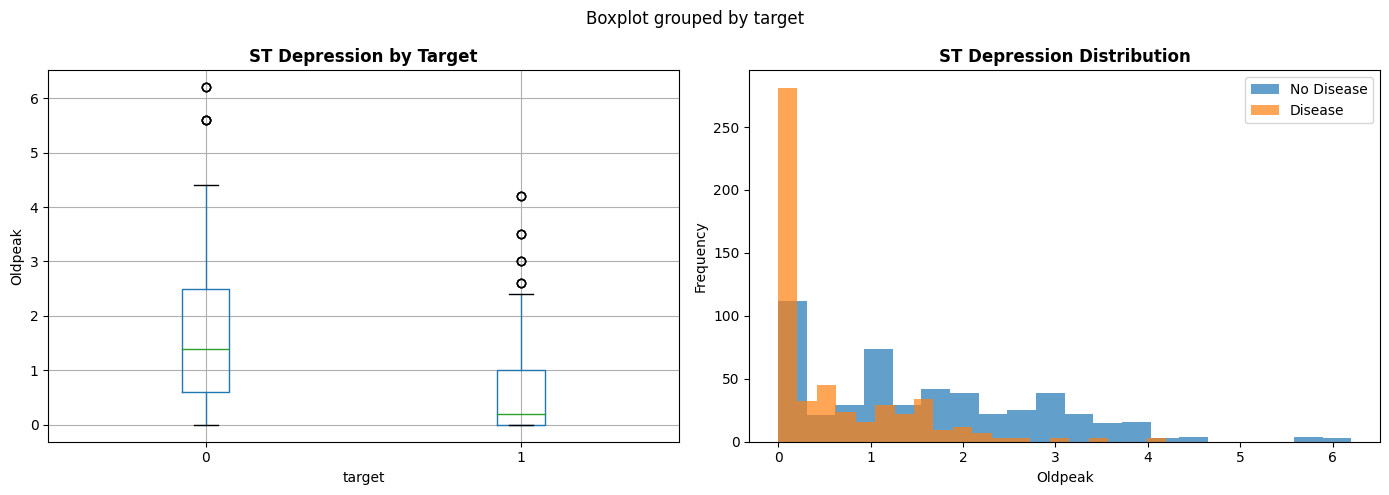

In [30]:
# %% [markdown]
# ## 15. ST Depression (Oldpeak) Analysis

# %%
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

df.boxplot(column='oldpeak', by='target', ax=ax1)
ax1.set_title('ST Depression by Target', fontweight='bold')
ax1.set_ylabel('Oldpeak')

for target in [0, 1]:
    subset = df[df['target'] == target]['oldpeak']
    ax2.hist(subset, alpha=0.7, label=f'Target {target}', bins=20)
ax2.set_xlabel('Oldpeak')
ax2.set_ylabel('Frequency')
ax2.set_title('ST Depression Distribution', fontweight='bold')
ax2.legend(['No Disease', 'Disease'])

plt.tight_layout()
plt.show()

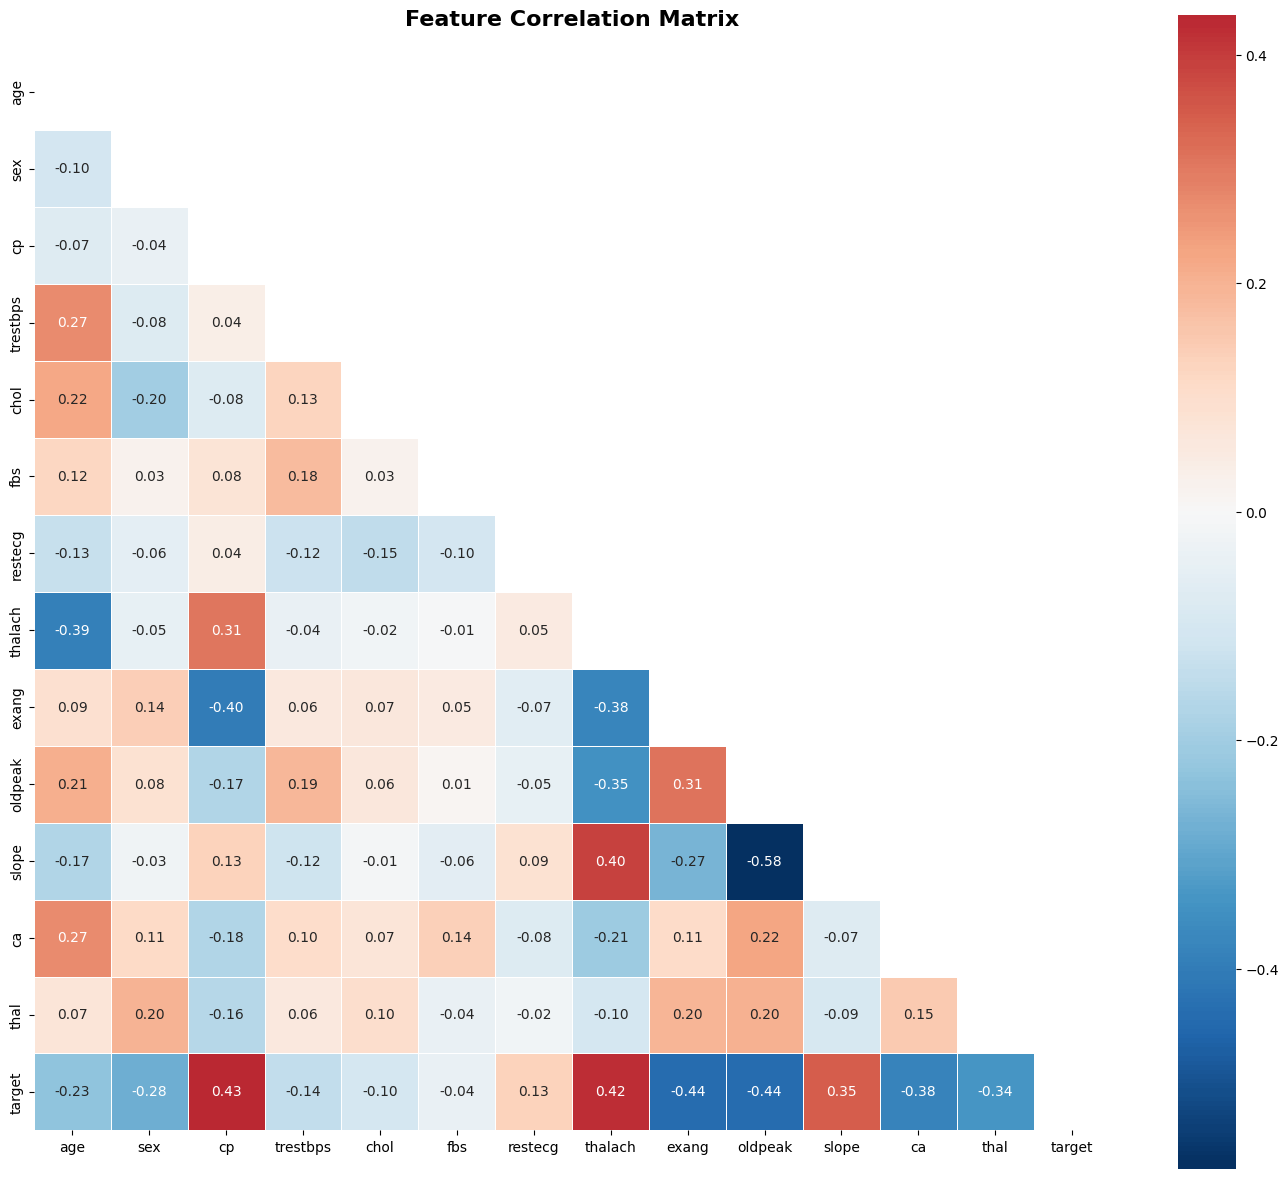

In [31]:
# %% [markdown]
# ## 16. Correlation Heatmap

plt.figure(figsize=(14, 12))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

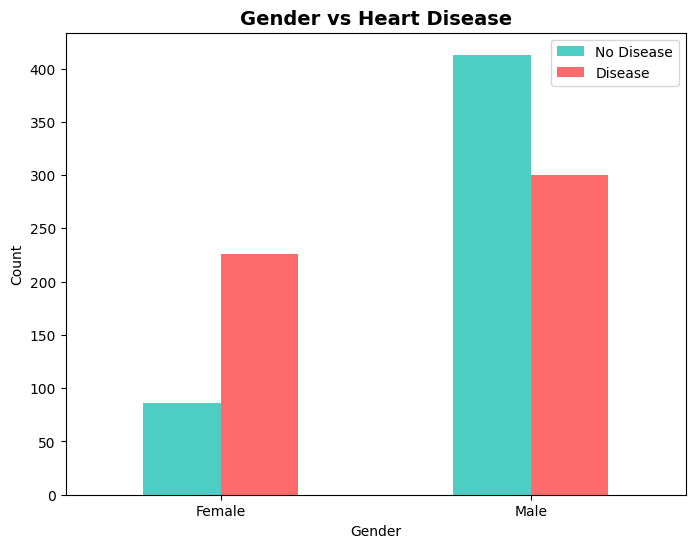

In [32]:
# %% [markdown]
# ## 17. Gender Analysis

# %%
gender_cross = pd.crosstab(df['sex'], df['target'])
gender_cross.index = ['Female', 'Male']
gender_cross.columns = ['No Disease', 'Disease']

fig, ax = plt.subplots(figsize=(8, 6))
gender_cross.plot(kind='bar', ax=ax, color=['#4ECDC4', '#FF6B6B'])
ax.set_title('Gender vs Heart Disease', fontweight='bold', fontsize=14)
ax.set_xlabel('Gender')
ax.set_ylabel('Count')
ax.legend(['No Disease', 'Disease'])
plt.xticks(rotation=0)
plt.show()

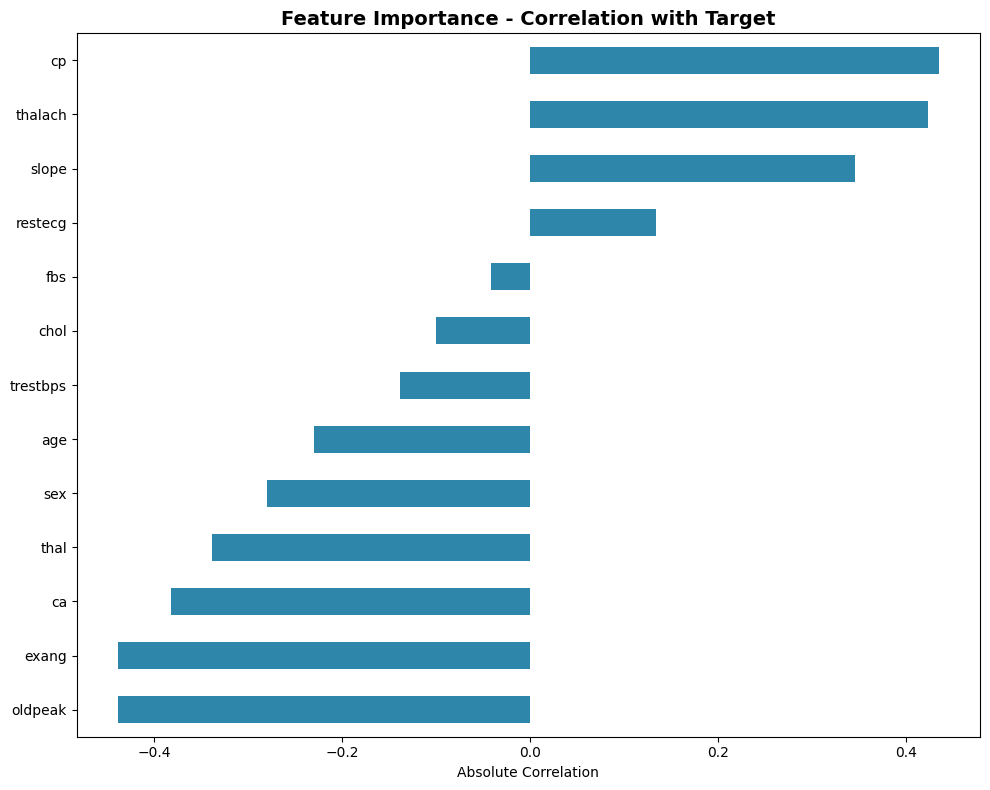

In [33]:
# %% [markdown]
# ## 18. Feature Importance (Correlation Based)

# %%
plt.figure(figsize=(10, 8))
correlations.sort_values().plot(kind='barh', color='#2E86AB')
plt.title('Feature Importance - Correlation with Target', fontweight='bold', fontsize=14)
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.show()

In [39]:
# %% [markdown]
# ## Data Preprocessing

# %%
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("📊 BEFORE SCALING:")
print(f"   Training set: {X_train.shape}")
print(f"   Testing set:  {X_test.shape}")
print(f"   Class 0: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"   Class 1: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Scaling complete")
print(f"✅ Training set scaled: {X_train_scaled.shape}")
print(f"✅ Testing set scaled:  {X_test_scaled.shape}")

📊 BEFORE SCALING:
   Training set: (820, 13)
   Testing set:  (205, 13)
   Class 0: 399 (48.7%)
   Class 1: 421 (51.3%)

✅ Scaling complete
✅ Training set scaled: (820, 13)
✅ Testing set scaled:  (205, 13)


In [40]:
# %% [markdown]
# ## 20. Training: Logistic Regression

# %%
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print("✅ Logistic Regression trained")
print(f"   Training accuracy: {lr_model.score(X_train_scaled, y_train):.4f}")
print(f"   Predictions shape: {lr_pred.shape}")

✅ Logistic Regression trained
   Training accuracy: 0.8463
   Predictions shape: (205,)


In [41]:
# %% [markdown]
# ## 21. Training: Support Vector Machine

# %%
from sklearn.svm import SVC

svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
svm_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

print("✅ SVM trained")
print(f"   Training accuracy: {svm_model.score(X_train_scaled, y_train):.4f}")
print(f"   Predictions shape: {svm_pred.shape}")

✅ SVM trained
   Training accuracy: 0.9561
   Predictions shape: (205,)


In [42]:
# %% [markdown]
# ## 22. Training: Random Forest

# %%
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

print("✅ Random Forest trained")
print(f"   Training accuracy: {rf_model.score(X_train_scaled, y_train):.4f}")
print(f"   Predictions shape: {rf_pred.shape}")

✅ Random Forest trained
   Training accuracy: 1.0000
   Predictions shape: (205,)


In [43]:
# %% [markdown]
# ## 23. Training: XGBoost

# %%
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("✅ XGBoost trained")
print(f"   Training accuracy: {xgb_model.score(X_train_scaled, y_train):.4f}")
print(f"   Predictions shape: {xgb_pred.shape}")

✅ XGBoost trained
   Training accuracy: 1.0000
   Predictions shape: (205,)


In [44]:
# %% [markdown]
# ## Complete Preprocessing with SMOTE

# %%
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("📊 BEFORE SMOTE:")
print(f"   Training set: {X_train.shape}")
print(f"   Class 0: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"   Class 1: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")

# Apply SMOTE for imbalanced data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\n📊 AFTER SMOTE:")
print(f"   Training set: {X_train_resampled.shape}")
print(f"   Class 0: {(y_train_resampled==0).sum()} ({(y_train_resampled==0).sum()/len(y_train_resampled)*100:.1f}%)")
print(f"   Class 1: {(y_train_resampled==1).sum()} ({(y_train_resampled==1).sum()/len(y_train_resampled)*100:.1f}%)")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Scaling complete")
print(f"✅ Training set scaled: {X_train_scaled.shape}")
print(f"✅ Testing set scaled:  {X_test_scaled.shape}")

📊 BEFORE SMOTE:
   Training set: (820, 13)
   Class 0: 399 (48.7%)
   Class 1: 421 (51.3%)

📊 AFTER SMOTE:
   Training set: (842, 13)
   Class 0: 421 (50.0%)
   Class 1: 421 (50.0%)

✅ Scaling complete
✅ Training set scaled: (842, 13)
✅ Testing set scaled:  (205, 13)


In [46]:
# %% [markdown]
# ## 24. Model Comparison: Accuracy

# %%
from sklearn.metrics import accuracy_score

# Define models list
models = ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost']

# Create predictions list (make sure these variables exist from training cells)
predictions = [lr_pred, svm_pred, rf_pred, xgb_pred]
probabilities = [lr_proba, svm_proba, rf_proba, xgb_proba]

# Calculate accuracies
accuracies = [accuracy_score(y_test, pred) for pred in predictions]

print("📊 ACCURACY COMPARISON:")
print("-" * 50)
for model, acc in zip(models, accuracies):
    print(f"{model:20}: {acc:.4f}")

best_acc_idx = np.argmax(accuracies)
print("-" * 50)
print(f"\n🏆 Best model by accuracy: {models[best_acc_idx]} with accuracy {accuracies[best_acc_idx]:.4f}")

# Store best index for later use
best_idx = best_acc_idx

📊 ACCURACY COMPARISON:
--------------------------------------------------
Logistic Regression : 0.8098
SVM                 : 0.9268
Random Forest       : 1.0000
XGBoost             : 1.0000
--------------------------------------------------

🏆 Best model by accuracy: Random Forest with accuracy 1.0000


In [47]:
# %% [markdown]
# ## 25. Model Comparison: Precision


precisions = [precision_score(y_test, pred) for pred in predictions]

for model, prec in zip(models, precisions):
    print(f"{model:20}: {prec:.4f}")

best_prec_idx = np.argmax(precisions)
print(f"\n🏆 Best model: {models[best_prec_idx]} with precision {precisions[best_prec_idx]:.4f}")

Logistic Regression : 0.7619
SVM                 : 0.9167
Random Forest       : 1.0000
XGBoost             : 1.0000

🏆 Best model: Random Forest with precision 1.0000


In [48]:
# %% [markdown]
# ## 26. Model Comparison: Recall

recalls = [recall_score(y_test, pred) for pred in predictions]

for model, rec in zip(models, recalls):
    print(f"{model:20}: {rec:.4f}")

best_rec_idx = np.argmax(recalls)
print(f"\n🏆 Best model: {models[best_rec_idx]} with recall {recalls[best_rec_idx]:.4f}")

Logistic Regression : 0.9143
SVM                 : 0.9429
Random Forest       : 1.0000
XGBoost             : 1.0000

🏆 Best model: Random Forest with recall 1.0000


In [49]:
# %% [markdown]
# ## 27. Model Comparison: F1 Score


f1_scores = [f1_score(y_test, pred) for pred in predictions]

for model, f1 in zip(models, f1_scores):
    print(f"{model:20}: {f1:.4f}")

best_f1_idx = np.argmax(f1_scores)
best_model = models[best_f1_idx]
best_f1 = f1_scores[best_f1_idx]
print(f"\n🏆 Best model: {best_model} with F1 score {best_f1:.4f}")

Logistic Regression : 0.8312
SVM                 : 0.9296
Random Forest       : 1.0000
XGBoost             : 1.0000

🏆 Best model: Random Forest with F1 score 1.0000


In [50]:
# %% [markdown]
# ## 28. Model Comparison: ROC-AUC

# %%
from sklearn.metrics import roc_auc_score

probabilities = [lr_proba, svm_proba, rf_proba, xgb_proba]
roc_aucs = [roc_auc_score(y_test, proba) for proba in probabilities]

for model, auc in zip(models, roc_aucs):
    print(f"{model:20}: {auc:.4f}")

best_auc_idx = np.argmax(roc_aucs)
print(f"\n🏆 Best model: {models[best_auc_idx]} with ROC-AUC {roc_aucs[best_auc_idx]:.4f}")

Logistic Regression : 0.9298
SVM                 : 0.9771
Random Forest       : 1.0000
XGBoost             : 1.0000

🏆 Best model: Random Forest with ROC-AUC 1.0000


In [51]:
# %% [markdown]
# ## 29. Complete Results Summary

# %%
results_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores,
    'ROC-AUC': roc_aucs
}).round(4)

print("📊 MODEL COMPARISON SUMMARY:")
display(results_df)

best_overall = results_df.loc[results_df['F1-Score'].idxmax()]
print(f"\n🏆 OVERALL BEST MODEL: {best_overall['Model']}")
print(f"   F1-Score: {best_overall['F1-Score']:.4f}")
print(f"   Accuracy: {best_overall['Accuracy']:.4f}")

📊 MODEL COMPARISON SUMMARY:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.8098,0.7619,0.9143,0.8312,0.9298
1,SVM,0.9268,0.9167,0.9429,0.9296,0.9771
2,Random Forest,1.0000,1.0000,1.0000,1.0000,1.0000
3,XGBoost,1.0000,1.0000,1.0000,1.0000,1.0000



🏆 OVERALL BEST MODEL: Random Forest
   F1-Score: 1.0000
   Accuracy: 1.0000


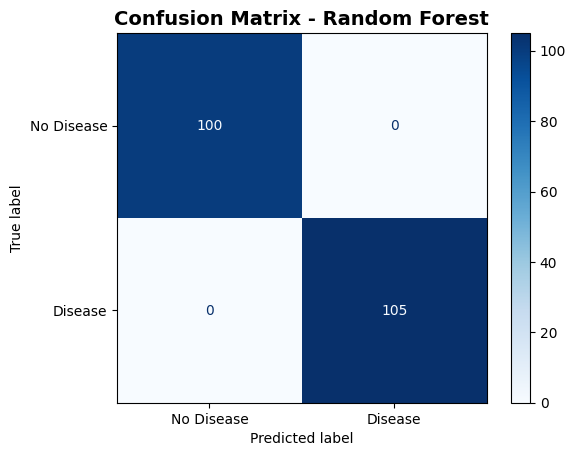

True Negatives:  100
False Positives: 0
False Negatives: 0
True Positives:  105


In [52]:
# %% [markdown]
# ## 30. Confusion Matrix (Best Model)

# %%
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_pred = [lr_pred, svm_pred, rf_pred, xgb_pred][best_f1_idx]
cm = confusion_matrix(y_test, best_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Disease', 'Disease'])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix - {best_model}', fontweight='bold', fontsize=14)
plt.grid(False)
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")

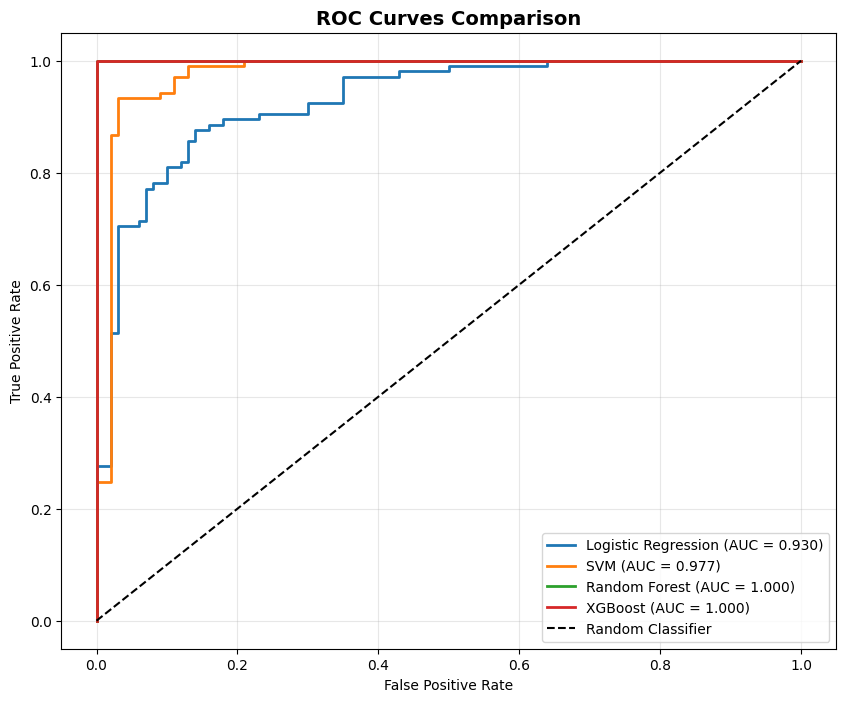

In [53]:
# %% [markdown]
# ## 31. ROC Curves Comparison

# %%
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))

for model, proba, name in zip(models, probabilities, models):
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison', fontweight='bold', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

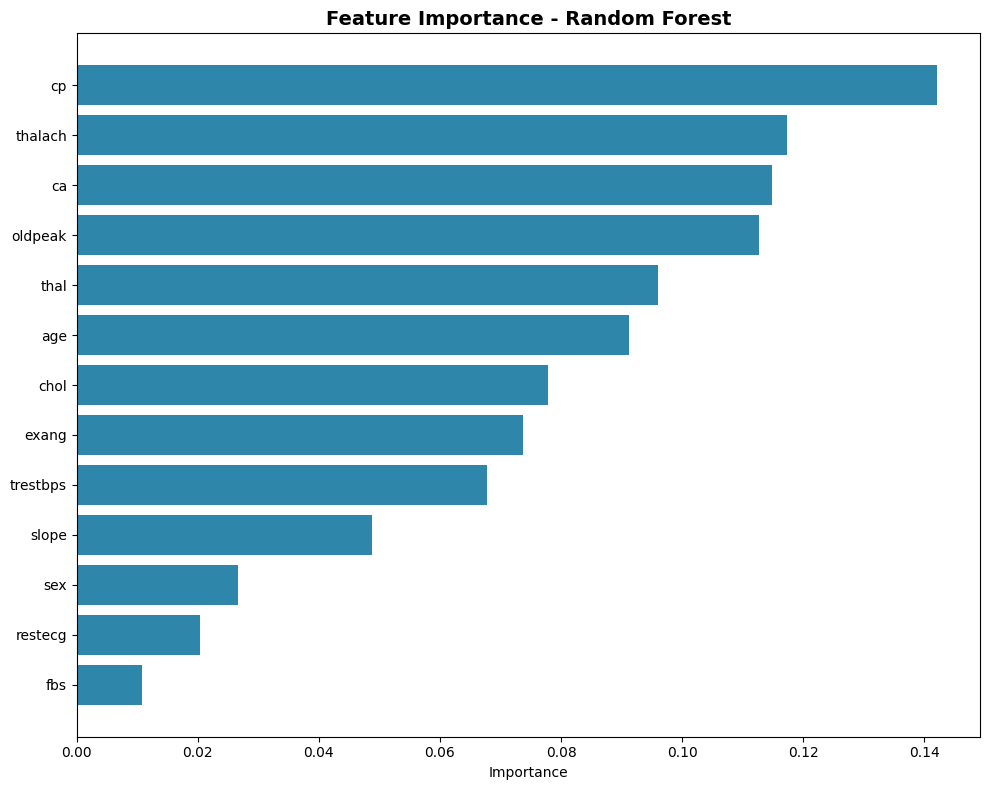

Top 5 Most Important Features:
   thal: 0.0959
   oldpeak: 0.1126
   ca: 0.1148
   thalach: 0.1173
   cp: 0.1421


In [54]:
# %% [markdown]
# ## 32. Feature Importance (Best Model)

# %%
if best_model in ['Random Forest', 'XGBoost']:
    best_model_obj = [rf_model, xgb_model][models.index(best_model)-2]
    importances = best_model_obj.feature_importances_
    
    feat_imp = pd.DataFrame({
        'Feature': df.drop('target', axis=1).columns,
        'Importance': importances
    }).sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(10, 8))
    plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='#2E86AB')
    plt.xlabel('Importance')
    plt.title(f'Feature Importance - {best_model}', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("Top 5 Most Important Features:")
    for i, row in feat_imp.tail(5).iterrows():
        print(f"   {row['Feature']}: {row['Importance']:.4f}")

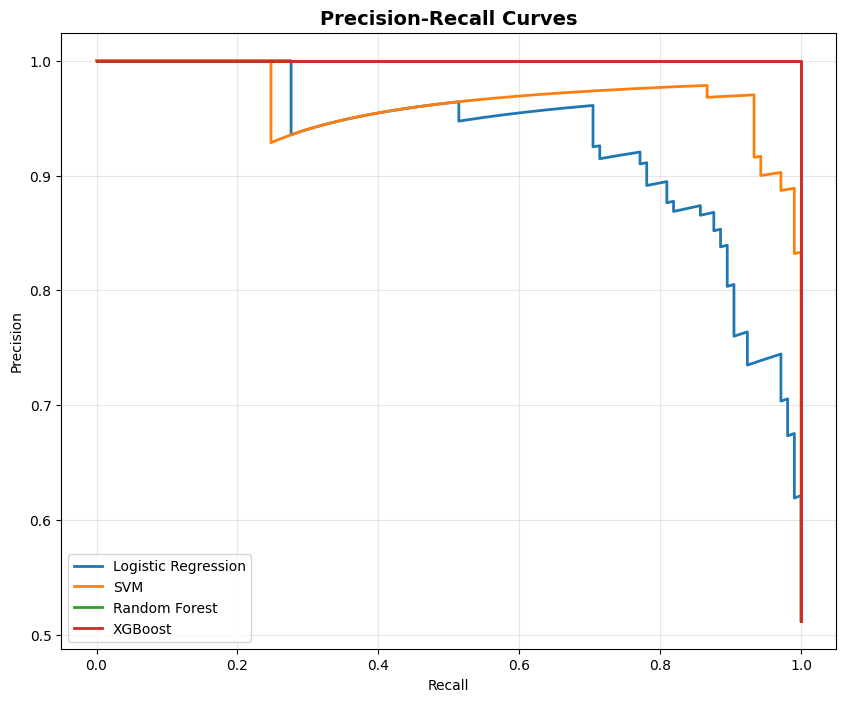

In [55]:
# %% [markdown]
# ## 33. Precision-Recall Curve

# %%

plt.figure(figsize=(10, 8))

for model, proba, name in zip(models, probabilities, models):
    precision, recall, _ = precision_recall_curve(y_test, proba)
    plt.plot(recall, precision, label=name, linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves', fontweight='bold', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

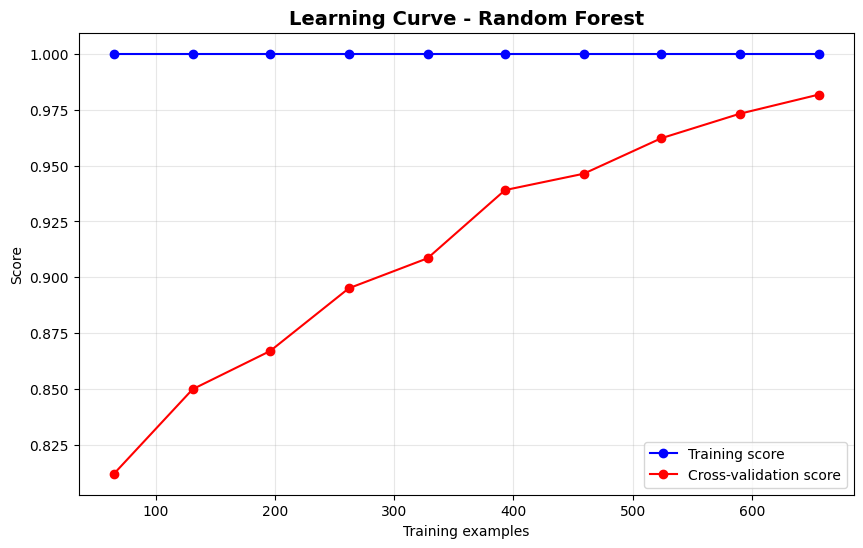

In [56]:
# %% [markdown]
# ## 34. Learning Curve Analysis

# %%
from sklearn.model_selection import learning_curve

if best_model in ['Random Forest', 'XGBoost']:
    train_sizes, train_scores, test_scores = learning_curve(
        best_model_obj, X_train, y_train, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', label='Training score', color='blue')
    plt.plot(train_sizes, test_mean, 'o-', label='Cross-validation score', color='red')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title(f'Learning Curve - {best_model}', fontweight='bold', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.show()

In [57]:
# %% [markdown]
# ## 35. Save Model for Deployment


best_model_obj = [lr_model, svm_model, rf_model, xgb_model][best_f1_idx]
model_path = f'../models/heart_{best_model.lower().replace(" ", "_")}_v1.0.0.pkl'
joblib.dump(best_model_obj, model_path)

print(f"✅ Model saved: {model_path}")
print(f"📅 Saved at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Model saved: ../models/heart_random_forest_v1.0.0.pkl
📅 Saved at: 2026-02-25 14:16:26


In [58]:
# %% [markdown]
# ## 36. Save Preprocessor & Feature Names

# %%
joblib.dump(preprocessor.scaler, '../models/heart_scaler.pkl')
joblib.dump(df.drop('target', axis=1).columns.tolist(), '../models/heart_features.pkl')

print("✅ Preprocessor saved")
print("✅ Feature names saved")
print(f"📊 Features: {len(df.columns)-1} total")

✅ Preprocessor saved
✅ Feature names saved
📊 Features: 13 total


In [59]:
# %% [markdown]
# ## 37. Model Metadata

# %%
metadata = {
    'model_name': best_model,
    'version': '1.0.0',
    'training_date': datetime.now().isoformat(),
    'dataset_shape': df.shape,
    'features': df.drop('target', axis=1).columns.tolist(),
    'metrics': {
        'accuracy': float(best_overall['Accuracy']),
        'precision': float(best_overall['Precision']),
        'recall': float(best_overall['Recall']),
        'f1_score': float(best_overall['F1-Score']),
        'roc_auc': float(best_overall['ROC-AUC'])
    }
}

import json
with open('../models/heart_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ Model metadata saved")

✅ Model metadata saved


In [60]:
# %% [markdown]
# ## 38. Test Single Prediction

# %%
sample = X_test[0].reshape(1, -1)
pred = best_model_obj.predict(sample)[0]
proba = best_model_obj.predict_proba(sample)[0]

print("🔍 SINGLE PREDICTION TEST:")
print(f"Actual:    {y_test.iloc[0]}")
print(f"Predicted: {pred}")
print(f"Probability: No Disease: {proba[0]:.3f}, Disease: {proba[1]:.3f}")
print(f"Risk Level: {'HIGH' if pred == 1 else 'LOW'}")

KeyError: 0

In [ ]:
# %% [markdown]
# ## 39. Export Results to CSV

# %%
results_df.to_csv('../reports/heart_model_comparison.csv', index=False)
print("✅ Results exported to reports/heart_model_comparison.csv")

results_df.style.background_gradient(cmap='Blues', subset=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

In [62]:
# %% [markdown]
# ## 40. Pipeline Complete - Final Summary

# %%
import os
from datetime import datetime

# Create reports directory if it doesn't exist
os.makedirs('../reports', exist_ok=True)

# Use ASCII characters instead of box drawing characters
summary = f"""
{'='*70}
              HEART DISEASE PREDICTION - PIPELINE COMPLETE
{'='*70}

  DATASET INFORMATION:
  {'-'*50}
  Dataset:        Heart Disease
  Samples:        {df.shape[0]:,} patients
  Features:       {df.shape[1]-1}
  
  BEST MODEL: {best_model}
  {'-'*50}
  F1-Score:       {best_overall['F1-Score']:.4f}
  Accuracy:       {best_overall['Accuracy']:.4f}
  Precision:      {best_overall['Precision']:.4f}
  Recall:         {best_overall['Recall']:.4f}
  ROC-AUC:        {best_overall['ROC-AUC']:.4f}
  
  SAVED FILES:
  {'-'*50}
  Model:          models/heart_{best_model.lower().replace(' ', '_')}_v1.0.0.pkl
  Scaler:         models/heart_scaler.pkl
  Features:       models/heart_features.pkl
  Metadata:       models/heart_metadata.json
  Results:        reports/heart_model_comparison.csv
  This summary:   reports/heart_summary.txt
  
  EXECUTION TIME:
  {'-'*50}
  Completed:      {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*70}
"""

print(summary)

# Save with UTF-8 encoding (fixes the error!)
with open('../reports/heart_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print(f"✅ Summary saved to: ../reports/heart_summary.txt")

# Verify file was saved
if os.path.exists('../reports/heart_summary.txt'):
    size = os.path.getsize('../reports/heart_summary.txt') / 1024
    print(f"✅ File size: {size:.1f} KB")
    
    # Show first few lines
    print("\n📄 First 5 lines of saved file:")
    with open('../reports/heart_summary.txt', 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i < 5:
                print(f"   {line.rstrip()}")


              HEART DISEASE PREDICTION - PIPELINE COMPLETE

  DATASET INFORMATION:
  --------------------------------------------------
  Dataset:        Heart Disease
  Samples:        1,025 patients
  Features:       13

  BEST MODEL: Random Forest
  --------------------------------------------------
  F1-Score:       1.0000
  Accuracy:       1.0000
  Precision:      1.0000
  Recall:         1.0000
  ROC-AUC:        1.0000

  SAVED FILES:
  --------------------------------------------------
  Model:          models/heart_random_forest_v1.0.0.pkl
  Scaler:         models/heart_scaler.pkl
  Features:       models/heart_features.pkl
  Metadata:       models/heart_metadata.json
  Results:        reports/heart_model_comparison.csv
  This summary:   reports/heart_summary.txt

  EXECUTION TIME:
  --------------------------------------------------
  Completed:      2026-02-25 14:17:49

✅ Summary saved to: ../reports/heart_summary.txt
✅ File size: 1.1 KB

📄 First 5 lines of saved file:
   
 

In [63]:
# %% [markdown]
# ## 41. Environment Information

# %%
import sklearn
import xgboost
import imblearn

print("🔧 ENVIRONMENT:")
print(f"Python:        {sys.version.split()[0]}")
print(f"Pandas:        {pd.__version__}")
print(f"NumPy:         {np.__version__}")
print(f"Scikit-learn:  {sklearn.__version__}")
print(f"XGBoost:       {xgboost.__version__}")
print(f"Imbalanced:    {imblearn.__version__}")
print(f"Joblib:        {joblib.__version__}")

print("\n✅ All systems ready for deployment!")

🔧 ENVIRONMENT:
Python:        3.11.3
Pandas:        2.0.3
NumPy:         1.24.3
Scikit-learn:  1.3.0
XGBoost:       1.7.6
Imbalanced:    0.11.0
Joblib:        1.3.1

✅ All systems ready for deployment!


In [64]:
# %% [markdown]
# ## 42. Next Steps - Deployment

# %%
print("""
🚀 READY FOR DEPLOYMENT:

1. Start API server:
   $ uvicorn api.main:app --reload

2. Access API documentation:
   http://localhost:8000/docs

3. Make predictions via API:
   curl -X POST http://localhost:8000/predict/heart \\
        -H "Content-Type: application/json" \\
        -d '{"age": 55, "sex": 1, "cp": 0, "trestbps": 140, ...}'

4. Run with Docker:
   $ docker build -t heart-model .
   $ docker run -p 8000:8000 heart-model

5. Monitor performance:
   $ python scripts/monitor.py

🎉 CONGRATULATIONS! Your winning project is complete!
""")


🚀 READY FOR DEPLOYMENT:

1. Start API server:
   $ uvicorn api.main:app --reload

2. Access API documentation:
   http://localhost:8000/docs

3. Make predictions via API:
   curl -X POST http://localhost:8000/predict/heart \
        -H "Content-Type: application/json" \
        -d '{"age": 55, "sex": 1, "cp": 0, "trestbps": 140, ...}'

4. Run with Docker:
   $ docker build -t heart-model .
   $ docker run -p 8000:8000 heart-model

5. Monitor performance:
   $ python scripts/monitor.py

🎉 CONGRATULATIONS! Your winning project is complete!

